# Lab: Schelling Model and its variants

The Schelling Model of Segregation, introduced by Thomas Schelling in the 1970s, is a foundational agent-based model used to study how local preferences can lead to large-scale spatial segregation, even when individuals only have mild biases. In the model, agents of different types (e.g., colors or groups) occupy a grid and move if their local neighborhood does not meet a certain satisfaction threshold—typically based on the proportion of similar neighbors. Despite its simplicity, the Schelling model reveals powerful insights about emergent collective behavior and is widely used in fields such as economics, sociology, and urban studies.

In this lab, we will implement and explore several key variants of the Schelling model to understand how changes in assumptions or rules can alter the system’s dynamics and outcomes. 

## Before We Start: Building a Flexible Framework

To systematically explore the Schelling model and its variants, we start by **decomposing the model into modular components**. This helps us better understand how individual choices and system rules affect emergent patterns.

We identify the following key components:

- **Initialization strategies**: how the city and agents are initially distributed  
  – *e.g.*, random placement, balanced layout, half-full blocks

- **Agent selection**: which agent moves next  
  – *e.g.*, random agent, agent with lowest utility

- **Target selection**: where the agent may want to move  
  – *e.g.*, random vacant cell, block with highest utility

- **Move acceptance rule**: when a move is allowed  
  – *e.g.*, only if personal utility increases, or social welfare increases, or via Metropolis-Hastings

- **Stopping criteria**: when to halt the simulation  
  – *e.g.*, fixed number of steps, or no more accepted moves

## A Simple Baseline Implementation

We now provide a basic implementation of this modular framework. You can think of this as a **template**, where different strategies can be plugged in to explore different behaviors.

This baseline version implements:

- A **random initialization** of agents across neighborhoods  
- A **random agent selection**  
- A **random target selection**  
- A **greedy acceptance rule**: only accept moves that improve individual utility

The goal here is to get familiar with the **basic data structures and control flow**.

### Project Structure and Baseline Overview

Our implementation is organized as a modular package `schelling/`, where each component of the simulation is separated into its own file. This makes it easier to understand, maintain, and extend.

Our codebase is organized into modular components. Each file contains one specific type of strategy or helper function. This design makes it easy to swap in new behaviors and explore different variants of the Schelling model.

- `initialization.py`: defines how agents are initially placed in the city
- `agent_selector.py`: strategy for choosing which agent moves
- `target_selector.py`: strategy for choosing where the agent might move
- `move_acceptor.py`: rule for deciding whether a move is accepted
- `stop_criterion.py`: determines when to stop the simulation
- `utils.py`: shared utility functions and plotting tools

Each module provides a **baseline implementation** that is simple but functional. You can find them in the respective `.py` files.

In the next cells, we will import and run the baseline strategy to demonstrate how the system works.

In [5]:
%load_ext autoreload
%autoreload 2
from schelling import *
import numpy as np

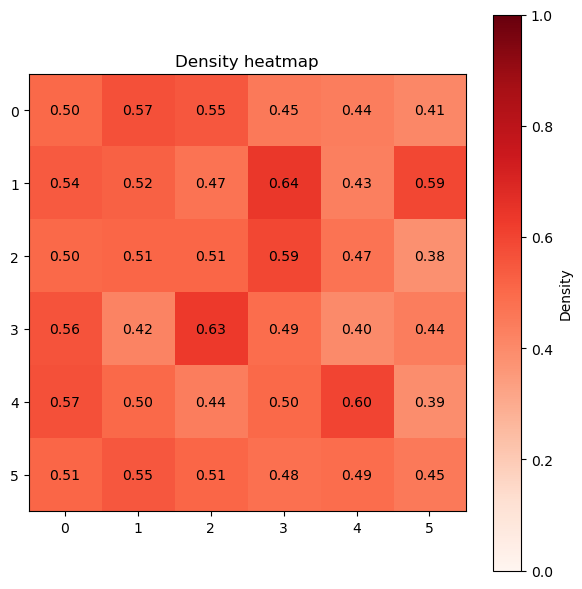

In [68]:
# === Parameters ===
Q = 36        # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = 100000

# === Initialize ===
occupied = initialization.init_random(Q, H, rho0)
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')


In [69]:

# === Main loop ===
for step in range(max_steps):

    # Stopping criterion
    if stop_criterion.stop_after_fixed_steps(step, max_steps):
        print(f"Stopped at step {step}")
        break

    # 1. Select an agent block (weighted by number of agents)
    from_block = agent_selector.select_agent_random(occupied)

    # 2. Select a target block (must have space)
    to_block = target_selector.select_target_random_cell(occupied, H)

    # 3. Check if move is accepted (Δu > 0)
    if move_acceptor.accept_if_personal_utility_improves(occupied[from_block] / H, (occupied[to_block] + 1) / H, utils.triangle_utility):
        occupied[from_block] -= 1
        occupied[to_block] += 1

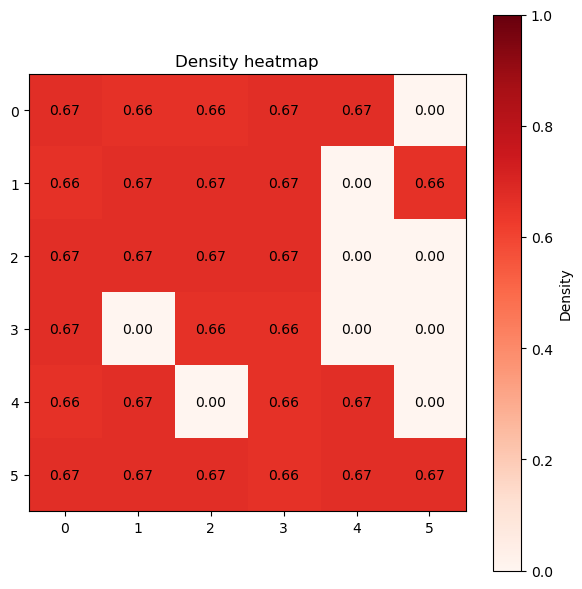

In [70]:
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')

## Version: 理性人

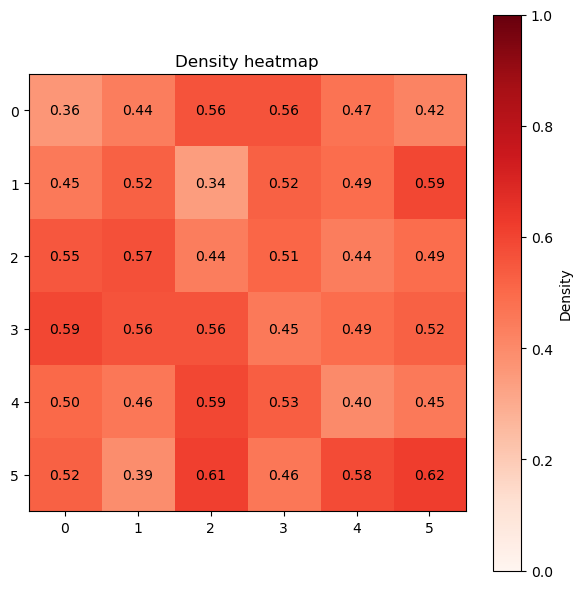

In [86]:
# === Parameters ===
Q = 36        # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = 100000
m = 10

# === Initialize ===
occupied = initialization.init_random(Q, H, rho0)
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')

In [87]:

# === Main loop ===
utility_func = lambda x: utils.asymmetric_triangle_utility(x, right_y=m)

for step in range(max_steps):

    # Stopping criterion
    if stop_criterion.stop_after_fixed_steps(step, max_steps):
        print(f"Stopped at step {step}")
        break

    # 1. Select an agent block (weighted by number of agents)
    from_block = agent_selector.select_agent_random(occupied)

    # 2. Select a target block (must have space)
    to_block = target_selector.select_target_max_utility(occupied, H, utility_func)

    # 3. Check if move is accepted (Δu > 0)
    if to_block is not None:
        occupied[from_block] -= 1
        occupied[to_block] += 1

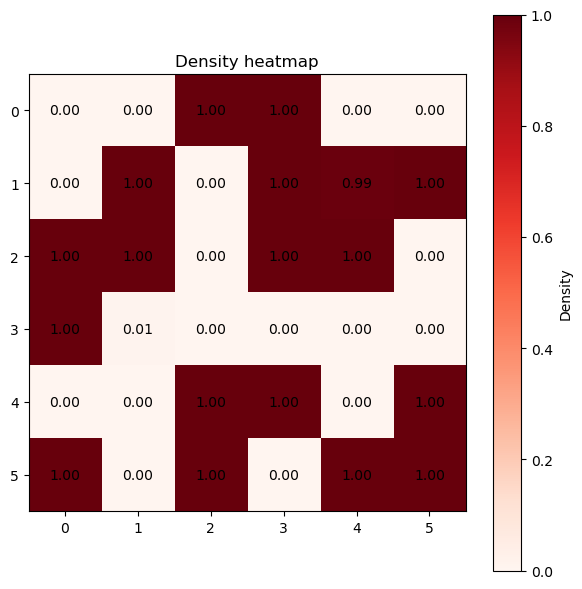

In [88]:
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')

## Version: 个人与集体

In [14]:
# === Parameters ===
Q = 36        # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = 100000
m = 0.0
alpha = 0.0
T = 0.01

In [ ]:
def version_1(Q, H, rho0, max_steps, m, alpha, T, m_tab = None):
    # === Initialize ===
    occupied = initialization.init_random(Q, H, rho0)
    # utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')
    # === Main loop ===
    utility_func = lambda x: utils.asymmetric_triangle_utility(x, right_y=m)

    step = 0
    while True:
        # Stopping criterion
        if stop_criterion.stop_after_fixed_steps(step, max_steps):
            print(f"Stopped at step {step}")
            break

        # 1. Select an agent block (weighted by number of agents)
        from_block = agent_selector.select_agent_random(occupied)

        # 2. Select a target block (must have space)
        to_block = target_selector.select_target_random_cell(occupied, H)

        # 3. Check if move is accepted (Δu > 0)
        if move_acceptor.accept_metropolis(from_block, to_block, occupied, H, utility_func, alpha, T, m_tab):
            occupied[from_block] -= 1
            occupied[to_block] += 1
        step += 1
        
    return occupied

In [ ]:
alphas = [0.1 * i for i in range(11)]
max_social_welfare = 1 * Q * H * rho0
PoAs = []
utility_func = lambda x: utils.asymmetric_triangle_utility(x, right_y=m)
for alpha in alphas:
    m_tab = move_acceptor.build_marginal_table(H, utility_func)
    occupied = version_1(Q, H, rho0, max_steps, m, alpha, T, m_tab)
    PoA = np.sum(utility_func(occupied / H) * occupied) / max_social_welfare
    PoAs.append(PoA)
    print(PoA)



Stopped at step 100000
0.7583555555555552
Stopped at step 100000
0.9712666666666666
Stopped at step 100000
0.971288888888889
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0
Stopped at step 100000
1.0


In [96]:
alphas = [0.1 * i for _ in range(3) for i in range(3)]
ms = [0.1 * i for i in range(3) for _ in range(3)]
ms, alphas
us = []

([0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2],
 [0.0, 0.1, 0.2, 0.0, 0.1, 0.2, 0.0, 0.1, 0.2])

In [2]:
utils.plot_line_chart(alphas, PoAs, title='m=0.0', xlabel='alpha', ylabel='average utility',
                    line_style='-', marker='o', color='b', label=None,
                    figsize=(8, 5), grid=True, legend=True)

NameError: name 'utils' is not defined

Stopped at step 100000


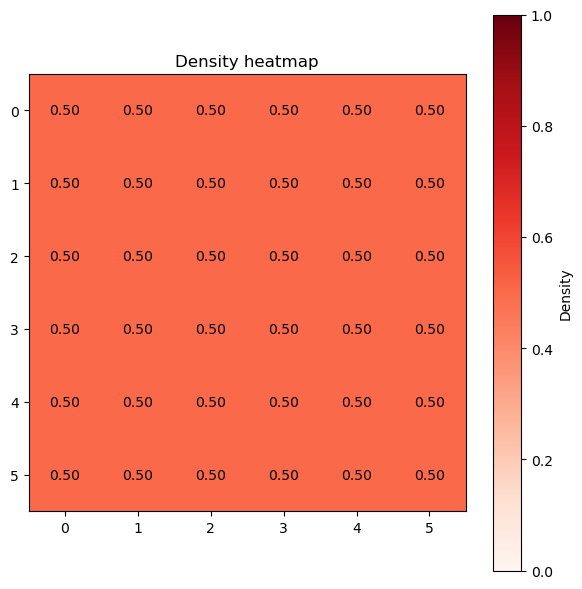

In [12]:
utils.plot_density_heatmap(6, 6, version_1(Q, H, rho0, max_steps, m=m, alpha=0.5, T=T) / H, title='Density heatmap', xlabel='', ylabel='')

## Version 3: Altruists

In [117]:
def version_3(Q, H, rho0, p, max_steps):
    # === Initialize ===
    occupied, agents = initialization.init_random_with_types(Q, H, rho0, p)
    utility_func = lambda agent_type: utils.triangle_utility if agent_type == 0 else utils.altruist_utility
    # === Main loop ===
    for step in range(max_steps):

        # Stopping criterion
        if stop_criterion.stop_after_fixed_steps(step, max_steps):
            print(f"Stopped at step {step}")
            break

        # 1. Select an agent block (weighted by number of agents)
        idx, from_block, agent_type = agent_selector.select_agent_random_with_types(agents)

        # 2. Select a target block (must have space)
        to_block = target_selector.select_target_random_cell(occupied, H)

        # 3. Check if move is accepted (Δu > 0)
        if move_acceptor.accept_if_personal_utility_improves(occupied[from_block] / H, (occupied[to_block] + 1) / H, utility_func(agent_type)):
            occupied[from_block] -= 1
            occupied[to_block] += 1
            agents[idx][0] = to_block
        
    return occupied, agents

In [127]:
# === Parameters ===
Q = 10       # number of neighborhoods
H = 100        # capacity per block
rho0 = 0.5    # initial global density
max_steps = int(1 * Q * H * rho0)
p = 1 / Q
occupied, agents = version_3(Q, H, rho0, p, max_steps)

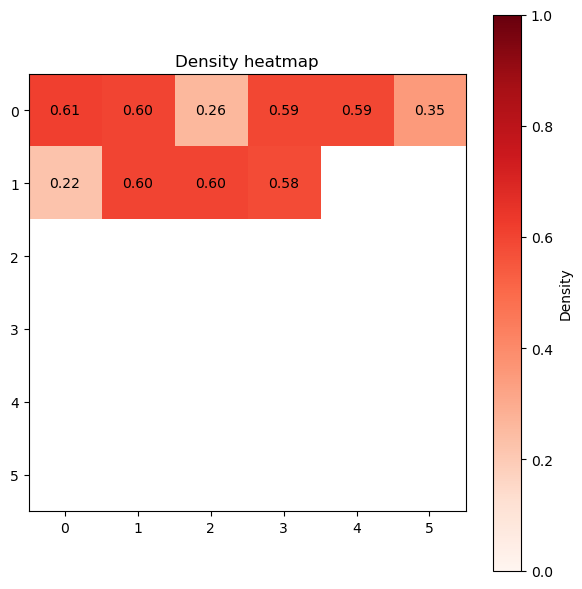

In [128]:
utils.plot_density_heatmap(6, 6, occupied / H, title='Density heatmap', xlabel='', ylabel='')

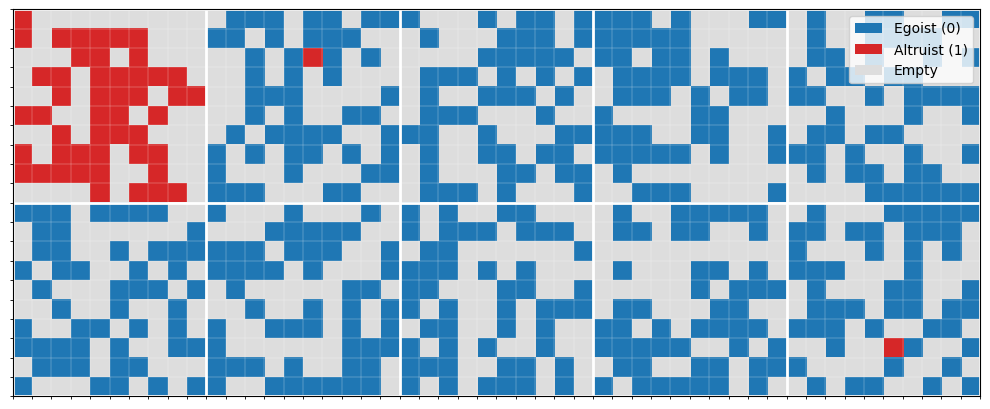

In [126]:
utils.plot_block_agents(2, 5, H, agents)